# Sprint 14 Project: Model Traning to Detect IMBD Negative Reviews

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. We'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least **0.85**.

The data was provided by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

Here's the description of the selected fields:
1. 'review': the review text
2. 'pos': the target, '0' for negative and '1' for positive
3. 'ds_part': 'train'/'test' for the train/test part of dataset, correspondingly

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df_reviews.shape

(47331, 17)

There are 47,331 rows with 17 columns for this dataset.

In [7]:
df_reviews.head(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
5,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,This is the first movie I've seen from Singapo...,9,pos,1,test,9282
6,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Yes non-Singaporean's can't see what's the big...,9,pos,1,test,9283
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904


In [8]:
# Check for missing data
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

There are only 2 rows with missing values, which is not significant.

In [9]:
# Check for duplicates
df_reviews.duplicated().sum()

0

In [10]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


## EDA

Let's check the number of movies and reviews over years.

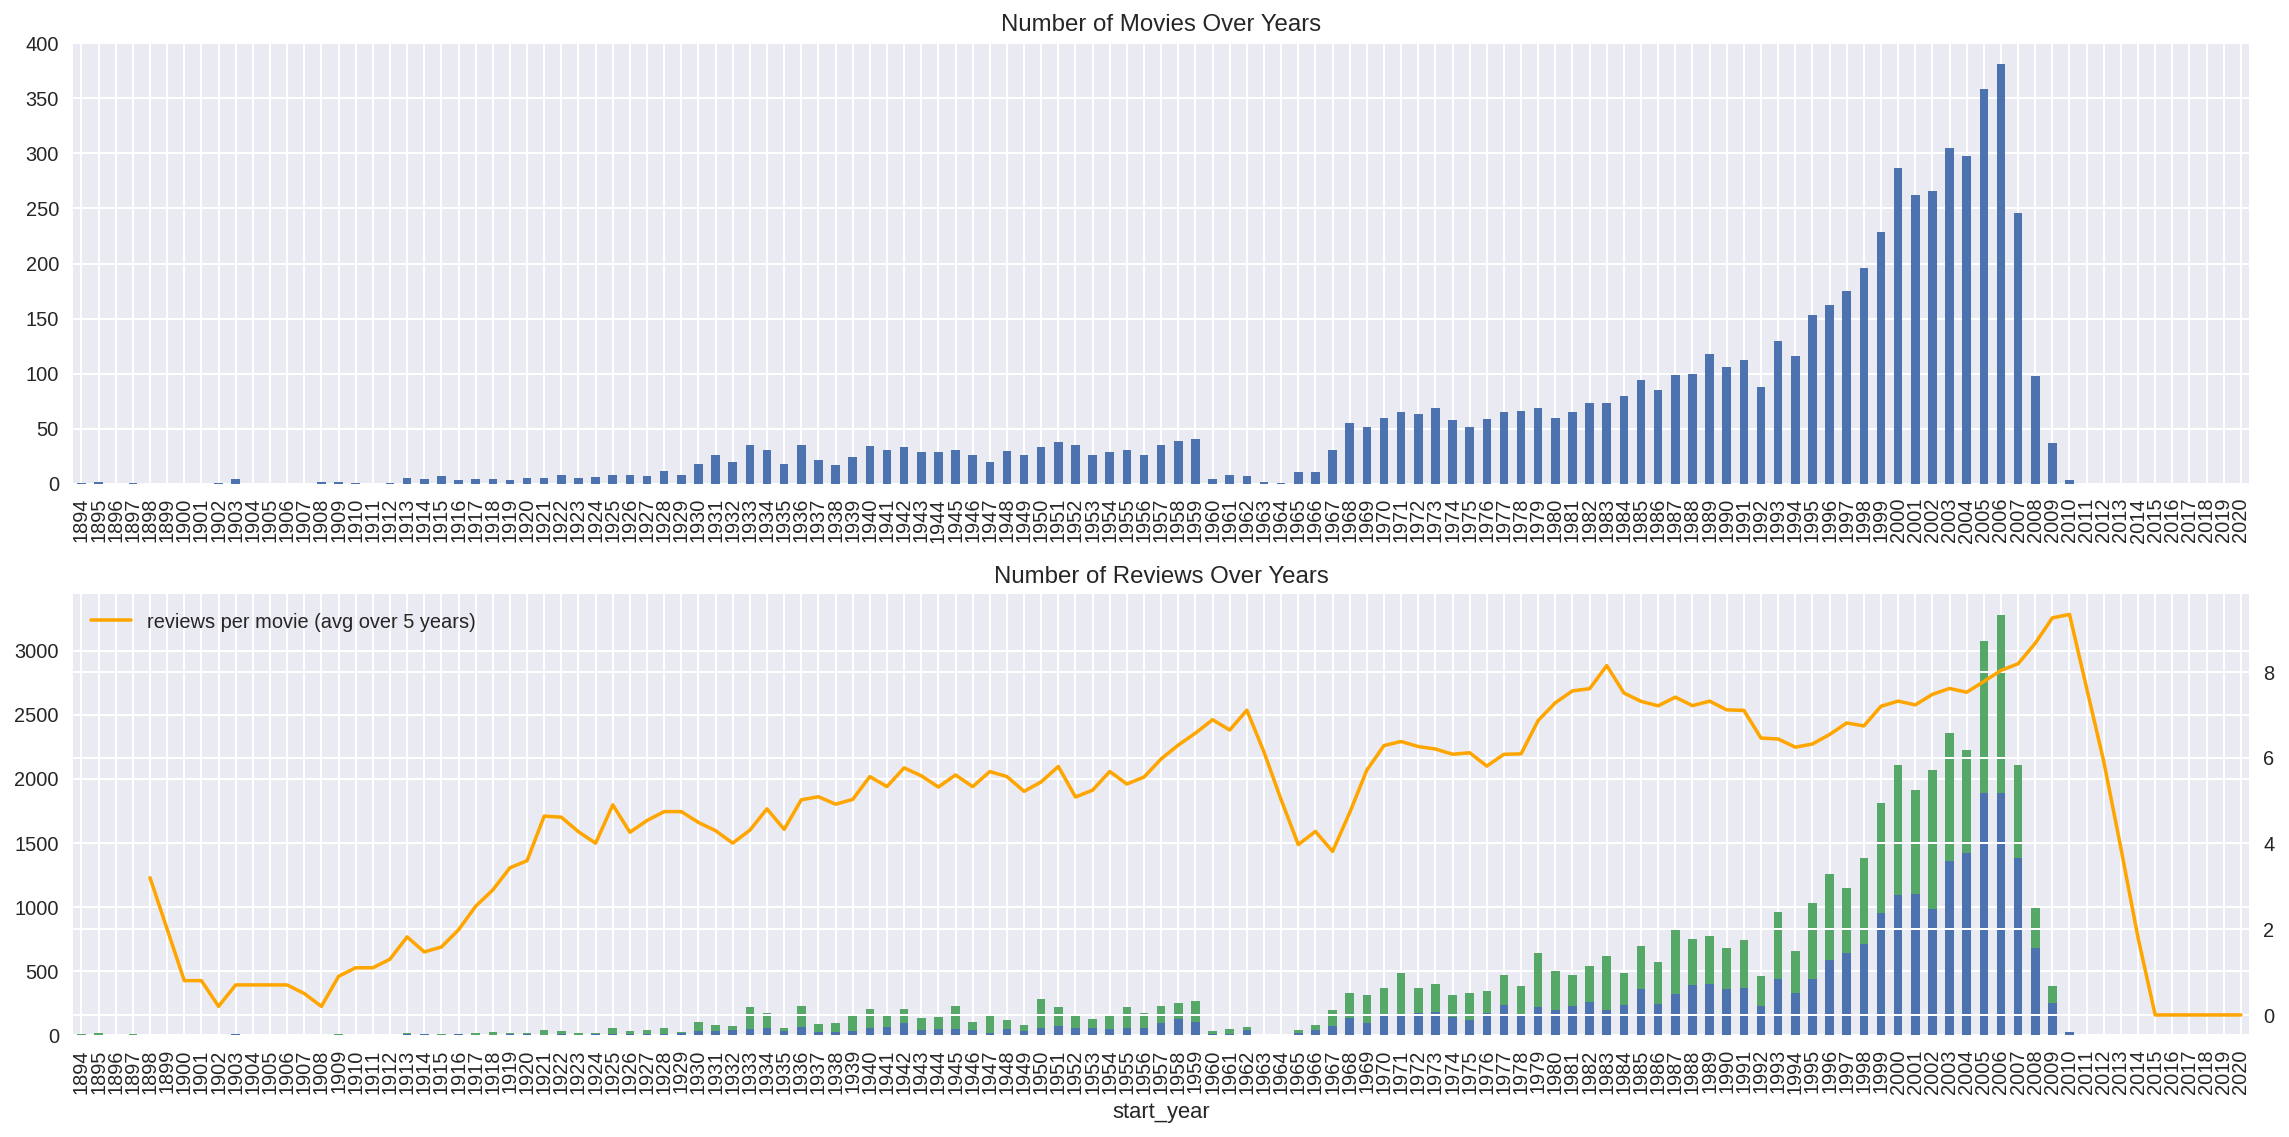

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

The numbers of movies are stagnant before year of 1958 and then increased since 1967 till 2006.
Sames go to the number of reviews.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

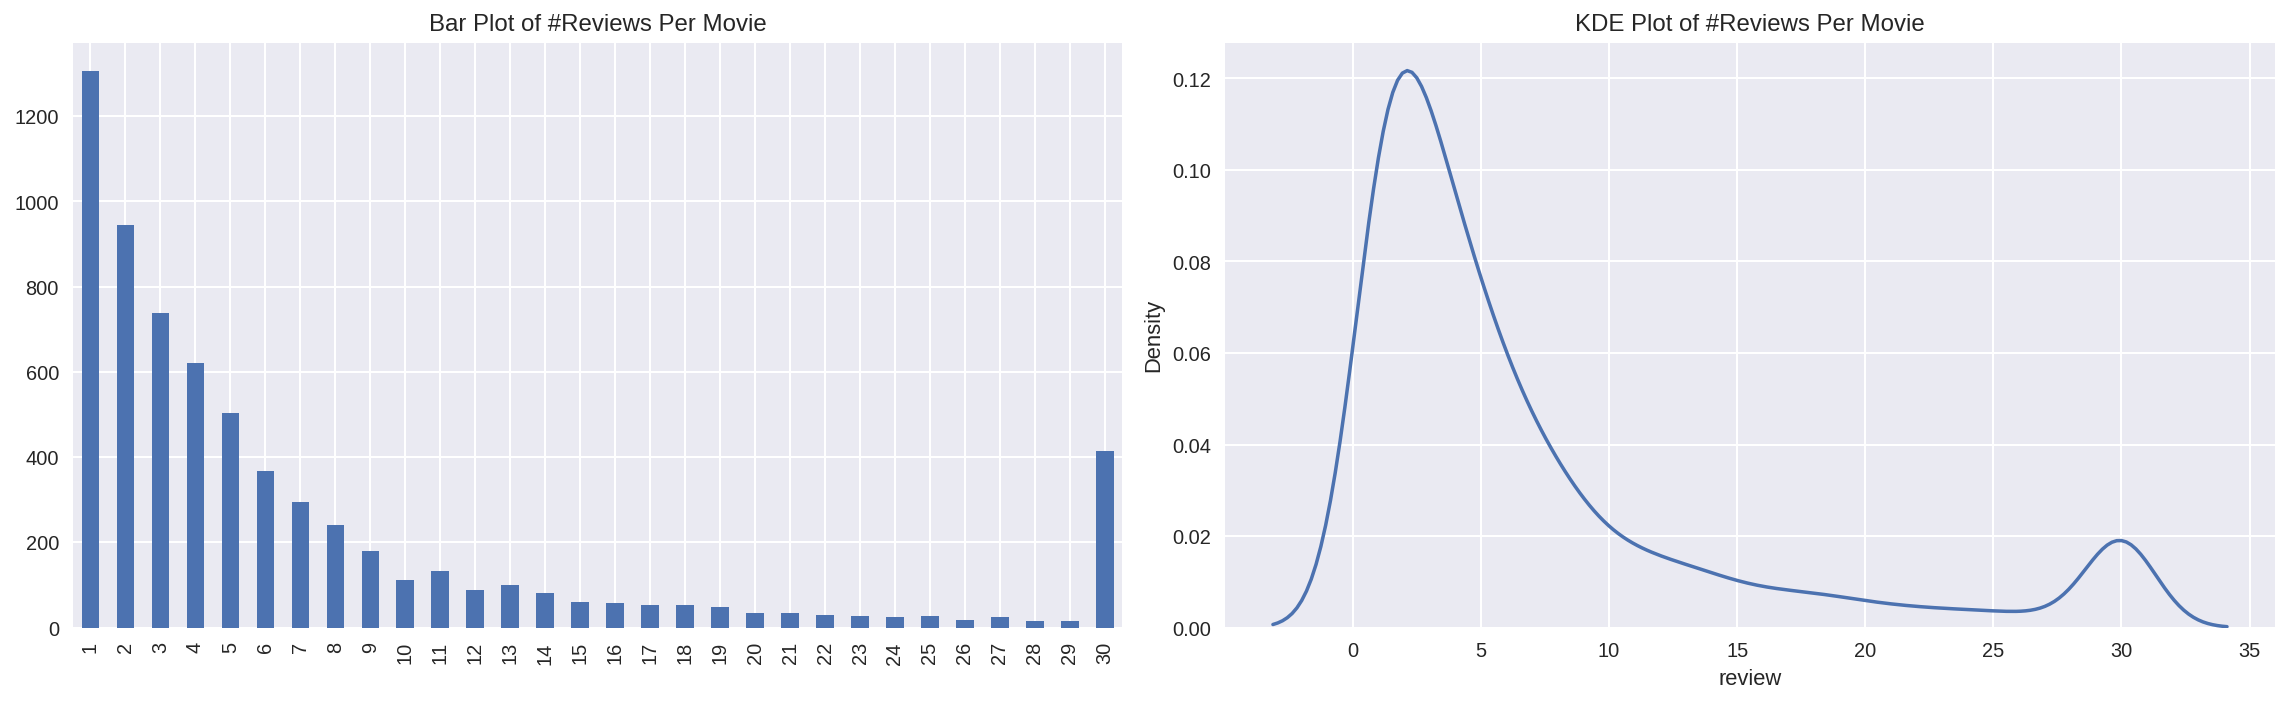

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The reviews per movie are mostly right skewed, most number of reviews are just below 10, and occisonally 30.

In [13]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

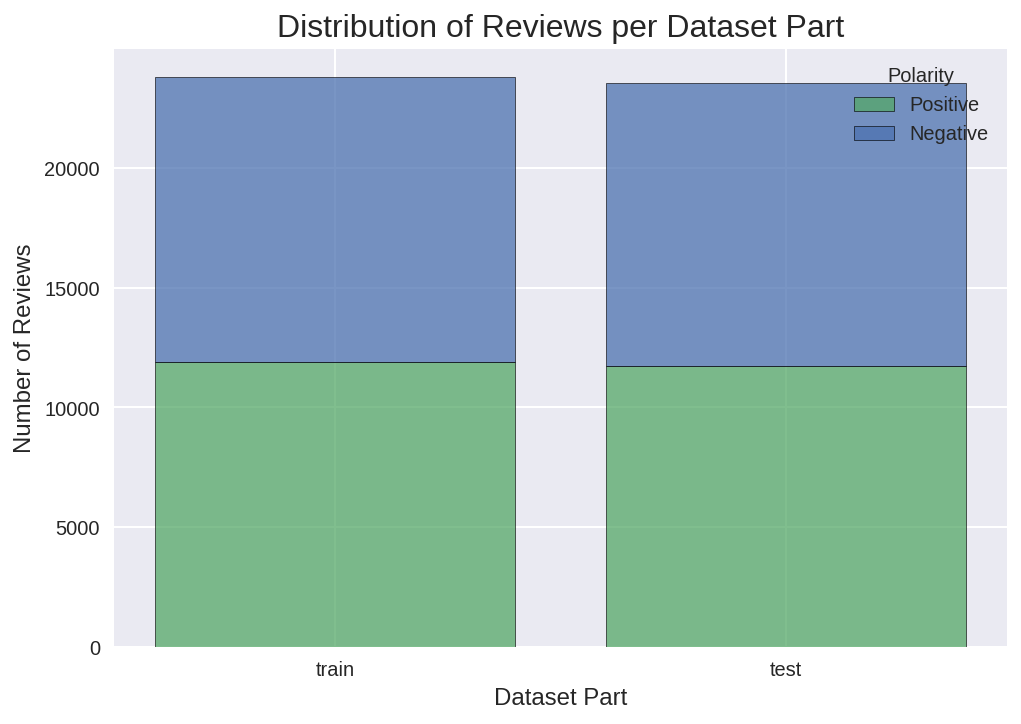

In [14]:
import seaborn as sns

g = sns.histplot(data=df_reviews, x='ds_part', hue='pos', multiple='stack', shrink=.8)
plt.xlabel('Dataset Part', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.legend(title='Polarity', loc='upper right', labels=['Positive', 'Negative'])
plt.title('Distribution of Reviews per Dataset Part', fontsize=16)

plt.show()

The positive and negative POS for the train & test dataset are almost the same. Thus, there is no class imbalance.

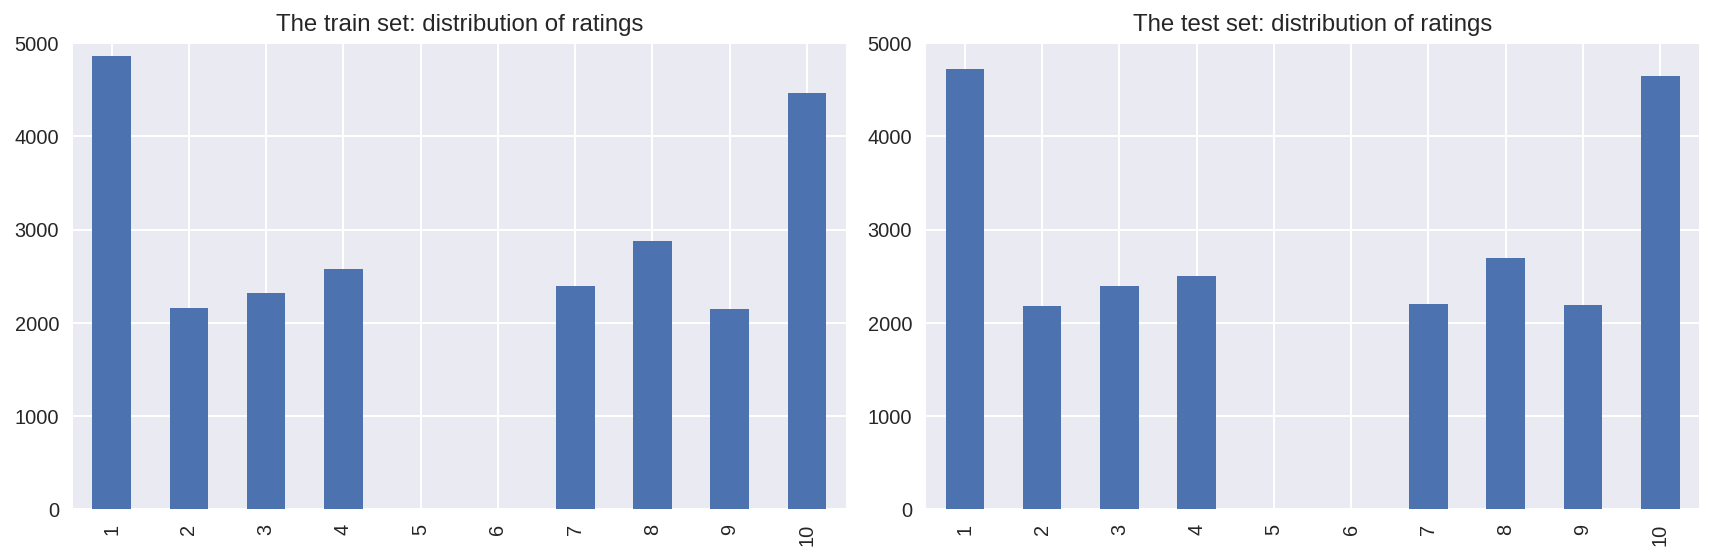

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


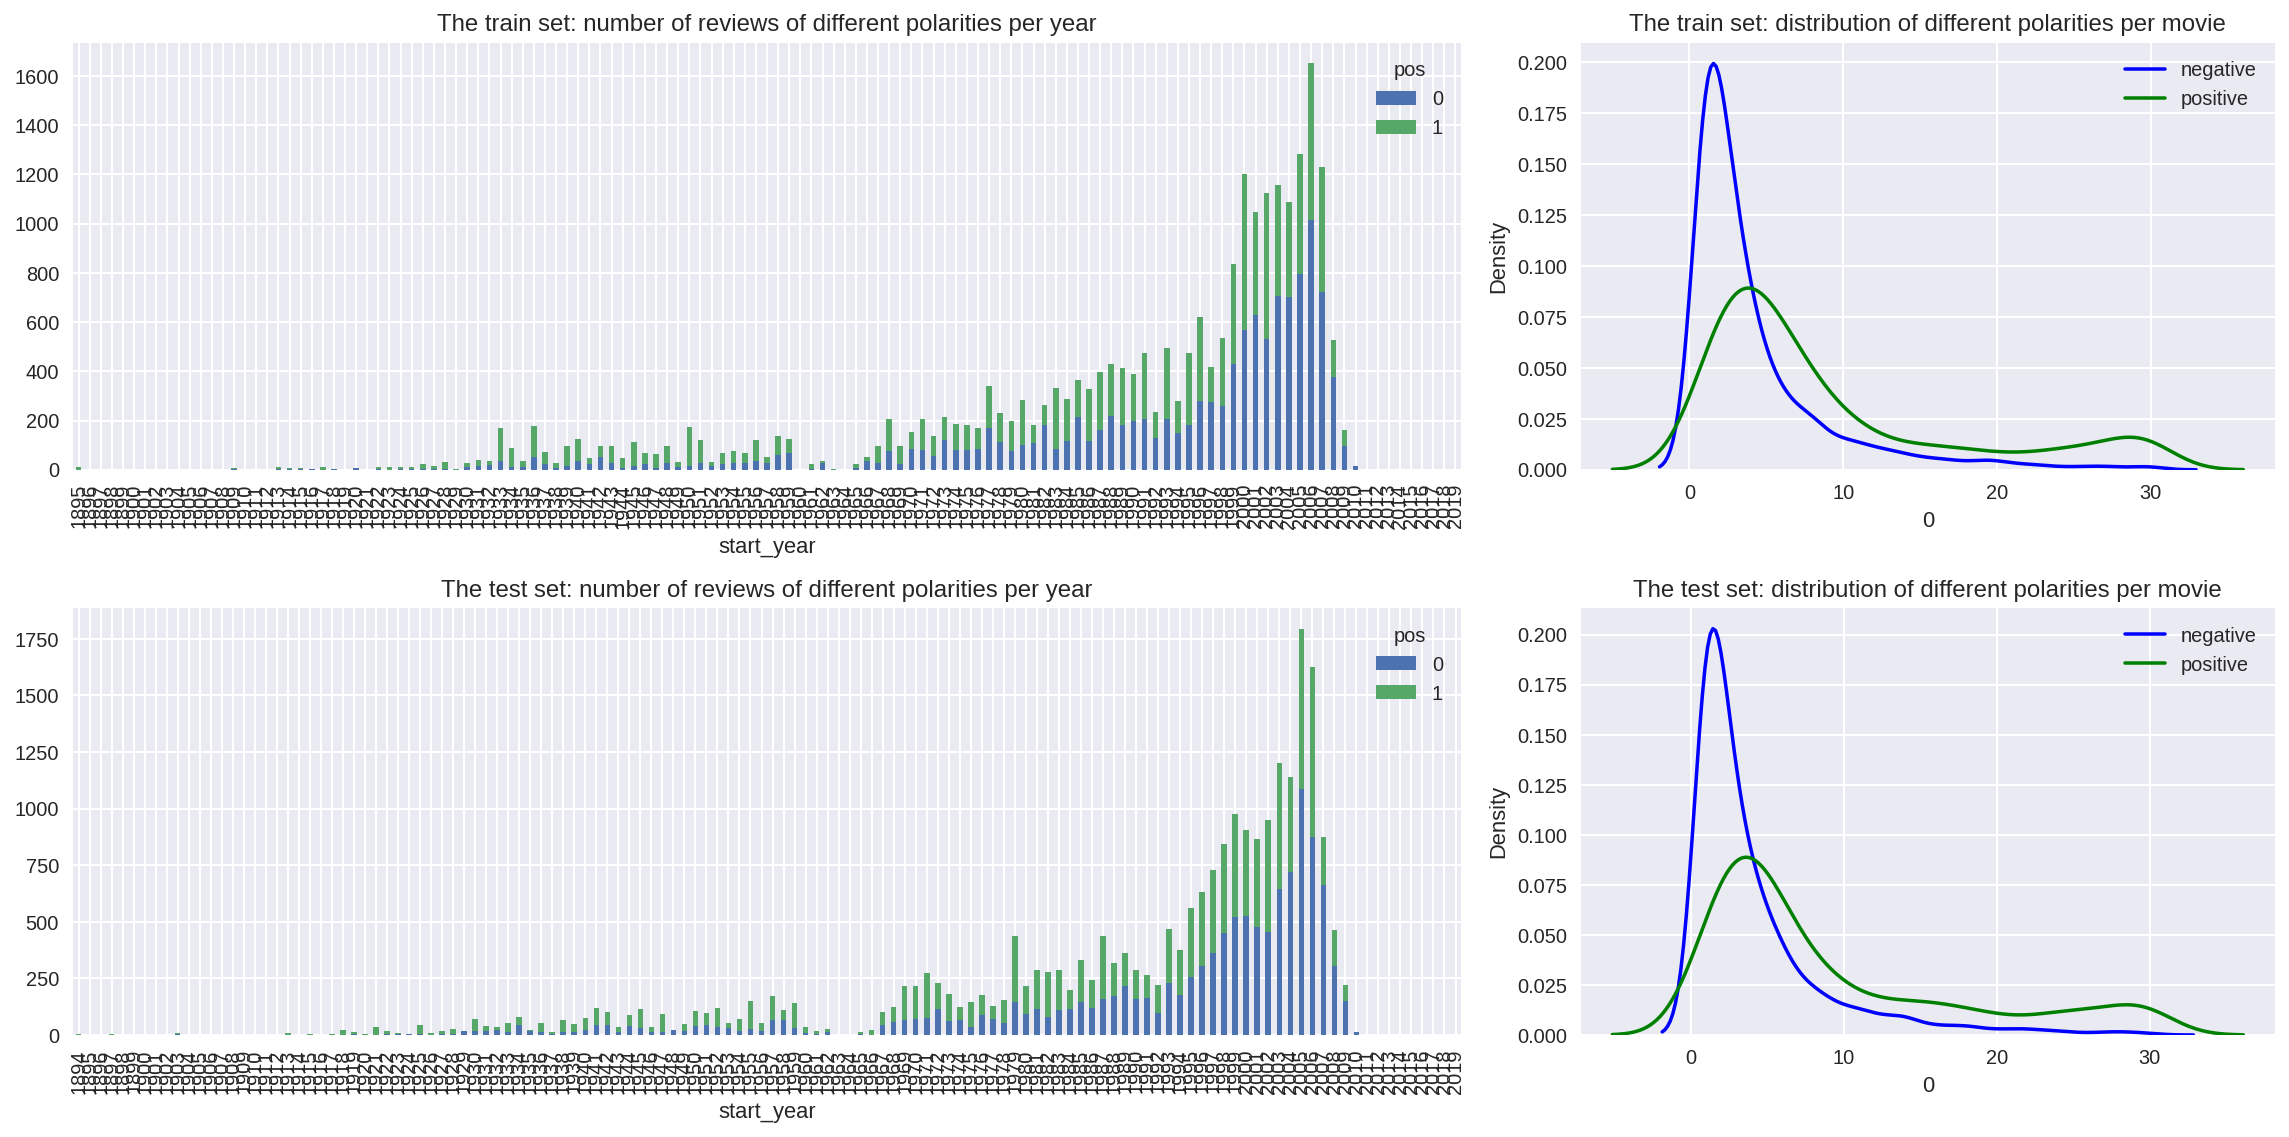

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The number of reviews of different polarities per year for train & test datasets increased rapidly after 1965. The number of reviews per movie for both train & test datasets ranged around 1-10 and peaked at around 2.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [17]:
import sklearn.metrics as metrics

def evaluate_model(model, model_name, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    # Add model name as a column
    df_eval_stats['Model'] = model_name
    
    print(df_eval_stats)
    
    return df_eval_stats


## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [18]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: " ".join(re.sub(r"[^A-Za-z]", " ", x.lower()).split()))

In [19]:
df_reviews.loc[99, 'review']

'In 1996\'s "101 Dalmatians," Cruella De Vil was arrested by the London Metropolitain Police (God bless them) for attempting to steal and murder 101 puppies - dalmatians. All covered in mud and hay, she spent the next 4 years in the "tin can." Now, 4 years later, she, unfortunately, was released from the jail. I say, that\'s about 28 years - in dog years!!!!! So, in 2000, Disney decided to release a sequel to the successful live-action version of the classic film and it is hereby dubbed "102 Dalmatians." In it, there is a 102nd dalmatian added to the family (Oddball is the name, I think; I should know this since this was just shown on TV recently), and the puppy had no spots!!!!! Also, while Cruella (again played by Glenn Close) has escaped again, she wanted a bigger, better coat - made once again out of the puppies!!!!! I especially liked the theme song - I\'m sure everybody loves the "Atomic Dog" song from the 70s or so. And now, we hear a bit of it in this movie!!!!! "102 Dalmatians

In [20]:
df_reviews.loc[99, 'review_norm']

'in s dalmatians cruella de vil was arrested by the london metropolitain police god bless them for attempting to steal and murder puppies dalmatians all covered in mud and hay she spent the next years in the tin can now years later she unfortunately was released from the jail i say that s about years in dog years so in disney decided to release a sequel to the successful live action version of the classic film and it is hereby dubbed dalmatians in it there is a nd dalmatian added to the family oddball is the name i think i should know this since this was just shown on tv recently and the puppy had no spots also while cruella again played by glenn close has escaped again she wanted a bigger better coat made once again out of the puppies i especially liked the theme song i m sure everybody loves the atomic dog song from the s or so and now we hear a bit of it in this movie dalmatians is such a great film that i keep on wondering when will there be a dalmatians lol stars'

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [21]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [22]:
from sklearn.dummy import DummyClassifier

In [23]:
# Set random state

random_state = 12345

In [24]:
train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

model_0 = DummyClassifier(strategy='stratified', random_state=random_state)

In [25]:
%%time
model_0.fit(train_features, train_target)

CPU times: user 2.21 ms, sys: 198 µs, total: 2.41 ms
Wall time: 1.56 ms


DummyClassifier(random_state=12345, strategy='stratified')

          train  test    Model
Accuracy    0.5   0.5  Model 0
F1          0.5   0.5  Model 0
APS         0.5   0.5  Model 0
ROC AUC     0.5   0.5  Model 0


,train,test,Model
Accuracy,0.5,0.5,Model 0
F1,0.5,0.5,Model 0
APS,0.5,0.5,Model 0
ROC AUC,0.5,0.5,Model 0


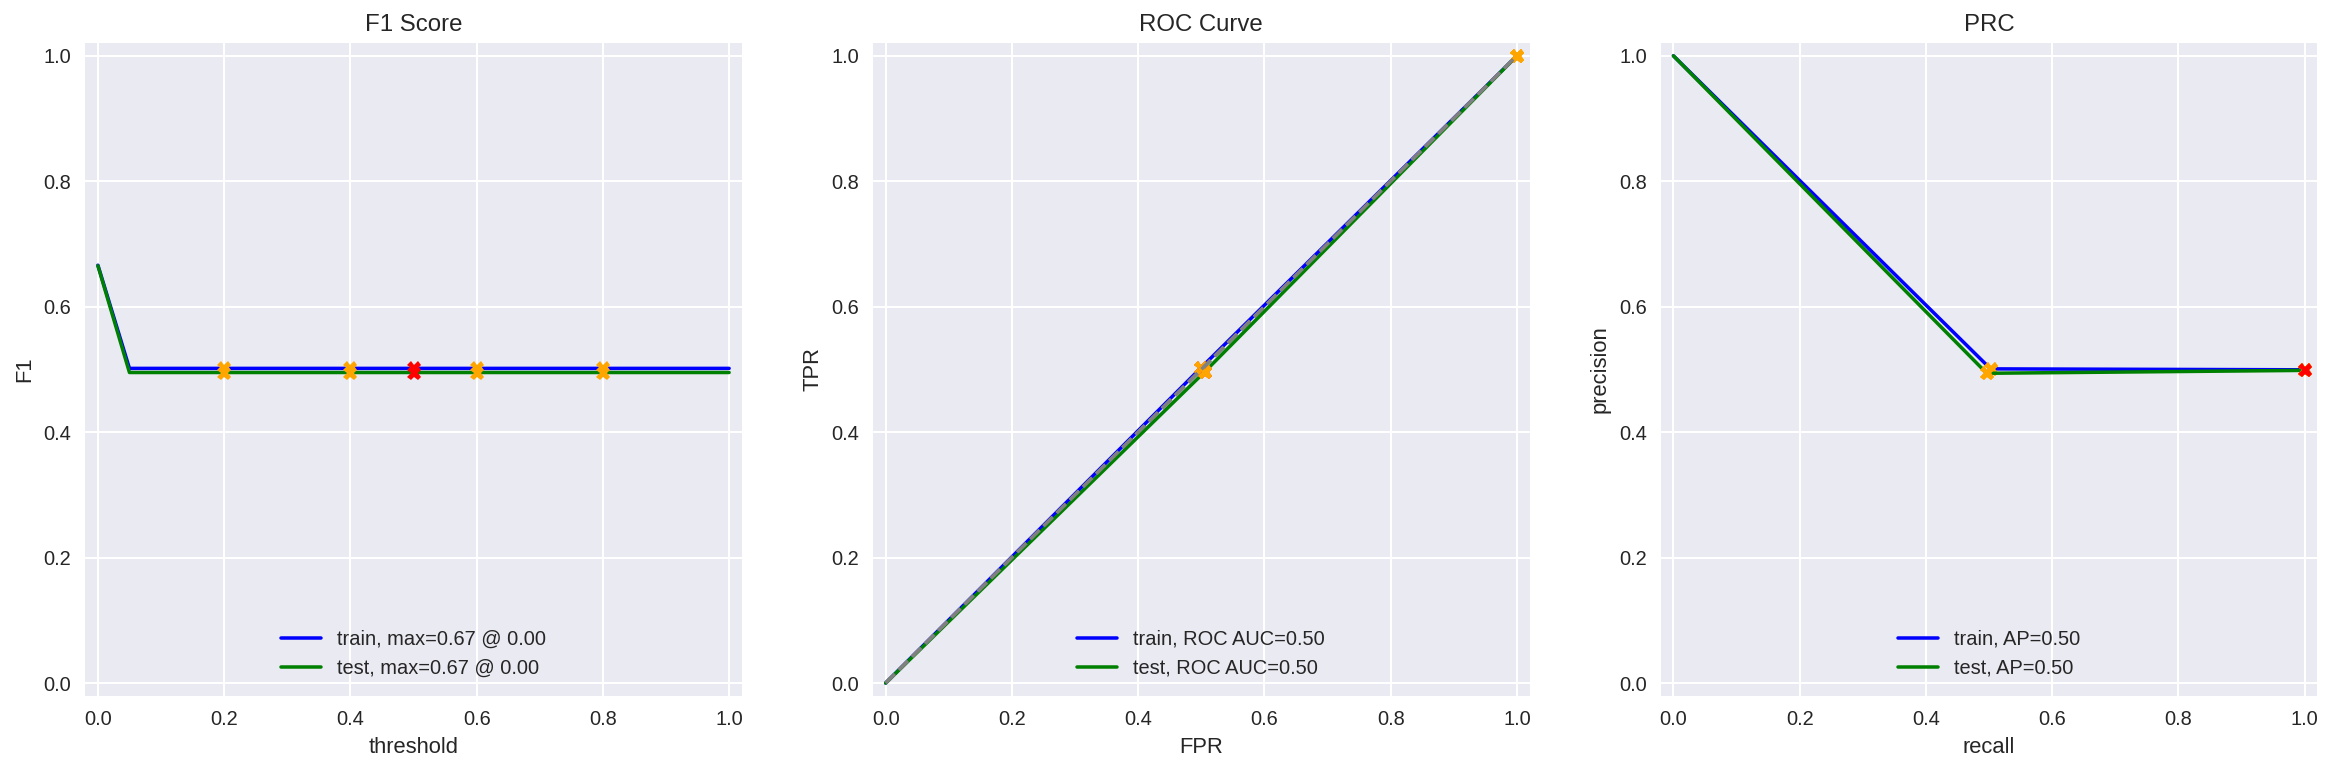

In [26]:
evaluate_model(model_0, "Model 0", train_features, train_target, test_features, test_target)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [27]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


In [28]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def preprocess_text_1(str_input):
    words_tokenized = word_tokenize(str_input)
    words_lemmatized = [lemmatizer.lemmatize(word) for word in words_tokenized]
    
    return " ".join(words_lemmatized)

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
df_reviews_train['review_norm_lemmatized'] = df_reviews_train['review_norm'].progress_apply(preprocess_text_1)
df_reviews_test['review_norm_lemmatized'] = df_reviews_test['review_norm'].progress_apply(preprocess_text_1)

train_features_1 = df_reviews_train['review_norm_lemmatized']
test_features_1 = df_reviews_test['review_norm_lemmatized']

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

In [30]:
stop_words = list(stopwords.words('english'))

model_1 = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words=stop_words)),
           ('lr', LogisticRegression(max_iter=300, random_state=random_state))]
)
model_1.fit(train_features_1, train_target)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('lr', LogisticRegression(max_iter=300, random_state=12345))])

In [31]:
params = {
    'lr__C': [0.1, 1, 10, 100]
}

grid_1 = GridSearchCV(model_1, params, scoring='f1', cv=3, n_jobs=-1, verbose=1)

grid_1.fit(train_features_1, train_target)

print(f'Best Parameters: {grid_1.best_params_}')
print(f'Best F1 Score: {grid_1.best_score_}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'lr__C': 1}
Best F1 Score: 0.8689915544958495


In [32]:
model_1 = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words=stop_words)),
           ('lr', LogisticRegression(random_state=random_state))]
)
model_1.fit(train_features_1, train_target)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('lr', LogisticRegression(random_state=12345))])

          train  test    Model
Accuracy   0.94  0.88  Model 1
F1         0.94  0.88  Model 1
APS        0.98  0.95  Model 1
ROC AUC    0.98  0.95  Model 1


,train,test,Model
Accuracy,0.94,0.88,Model 1
F1,0.94,0.88,Model 1
APS,0.98,0.95,Model 1
ROC AUC,0.98,0.95,Model 1


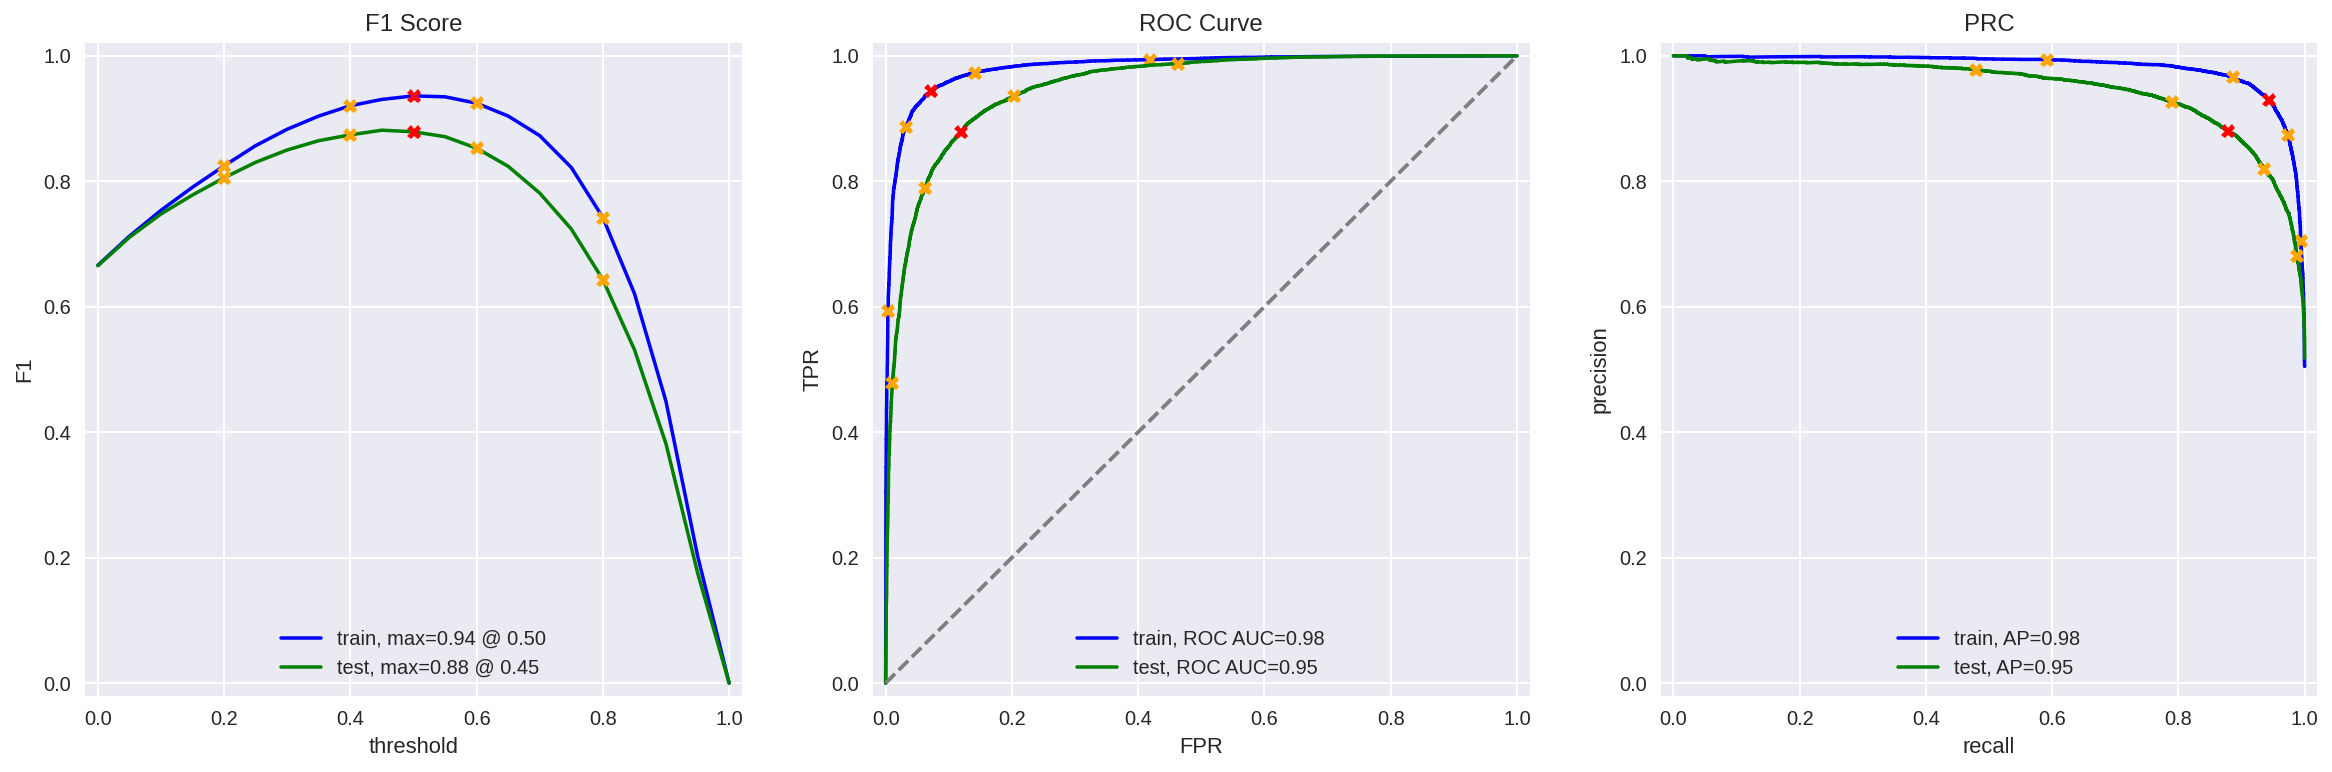

In [33]:
evaluate_model(model_1, "Model 1", train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [34]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [35]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [36]:
train_features_3 = df_reviews_train['review_norm'].progress_apply(text_preprocessing_3)
test_features_3 = df_reviews_test['review_norm'].progress_apply(text_preprocessing_3)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

In [37]:
model_3 = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words=stop_words)),
           ('lr', LogisticRegression(max_iter=300, random_state=random_state))]
)
model_3.fit(train_features_3, train_target)

params = {
    'lr__C': [0.1, 1, 10, 100]
}

grid_3 = GridSearchCV(model_3, params, scoring='f1', cv=3, n_jobs=-1, verbose=1)

grid_3.fit(train_features, train_target)

print(f'Best Parameters: {grid_3.best_params_}')
print(f'Best F1 Score: {grid_3.best_score_}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'lr__C': 1}
Best F1 Score: 0.8706880421461568


In [38]:
model_3 = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words=stop_words)),
           ('lr', LogisticRegression(random_state=random_state))]
)
model_3.fit(train_features_3, train_target)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('lr', LogisticRegression(random_state=12345))])

          train  test    Model
Accuracy   0.93  0.88  Model 3
F1         0.93  0.88  Model 3
APS        0.98  0.95  Model 3
ROC AUC    0.98  0.95  Model 3


,train,test,Model
Accuracy,0.93,0.88,Model 3
F1,0.93,0.88,Model 3
APS,0.98,0.95,Model 3
ROC AUC,0.98,0.95,Model 3


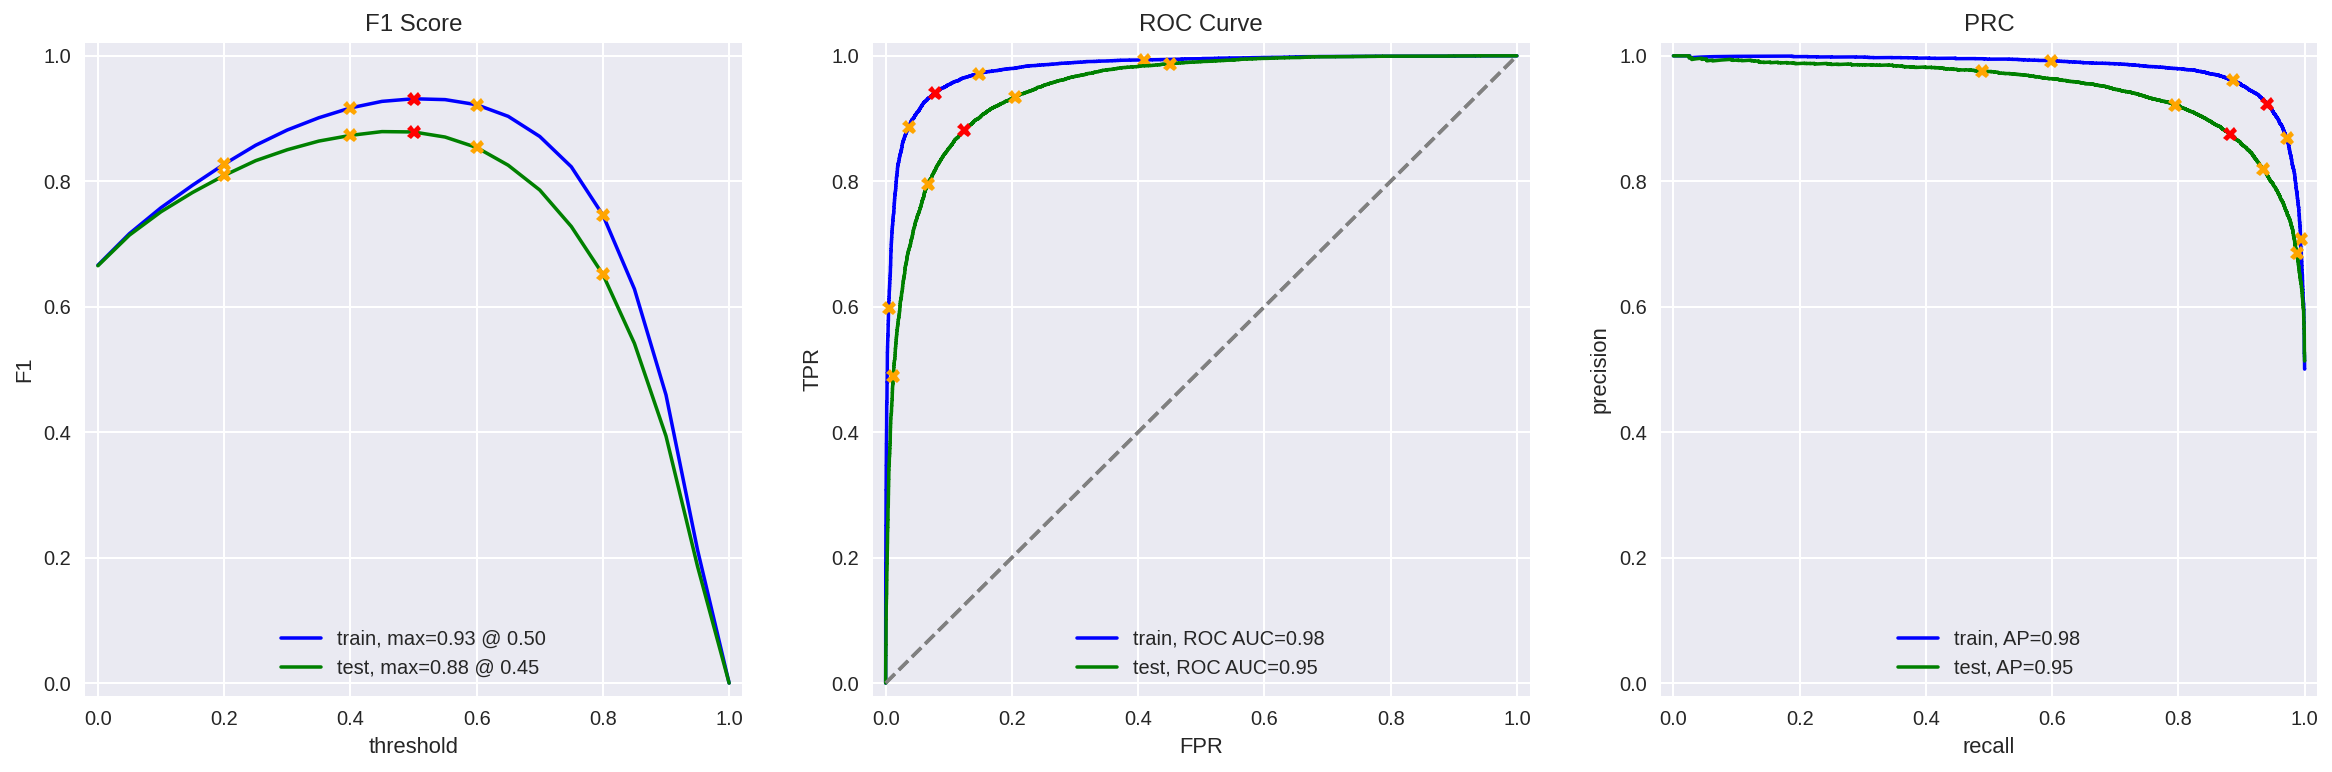

In [39]:
evaluate_model(model_3, "Model 3", train_features_3, train_target, test_features_3, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [40]:
from lightgbm import LGBMClassifier

In [41]:
model_4 = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words=stop_words)),
           ('lgbm', LGBMClassifier(force_row_wise=True, random_state=random_state, verbose=0))]
)

params = {
    'lgbm__learning_rate': [0.1, 0.2],
    'lgbm__n_estimators': [200, 300],
    'lgbm__num_leaves': [32, 64] 
}

grid_4 = GridSearchCV(model_4, params, scoring='f1', cv=3, n_jobs=-1, verbose=1)

grid_4.fit(train_features_3, train_target)

print(f'Best Parameters: {grid_4.best_params_}')
print(f'Best F1 Score: {grid_4.best_score_}')

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'lgbm__learning_rate': 0.2, 'lgbm__n_estimators': 300, 'lgbm__num_leaves': 64}
Best F1 Score: 0.8613338326249065


In [42]:
model_4 = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words=stop_words)),
           ('lr', LGBMClassifier(learning_rate=0.2, num_leaves=64, n_estimators=300, random_state=random_state))]
)
model_4.fit(train_features_3, train_target)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('lr',
                 LGBMClassifier(learning_rate=0.2, n_estimators=300,
                                num_leaves=64, random_state=12345))])

          train  test    Model
Accuracy    1.0  0.87  Model 4
F1          1.0  0.87  Model 4
APS         1.0  0.94  Model 4
ROC AUC     1.0  0.95  Model 4


,train,test,Model
Accuracy,1.0,0.87,Model 4
F1,1.0,0.87,Model 4
APS,1.0,0.94,Model 4
ROC AUC,1.0,0.95,Model 4


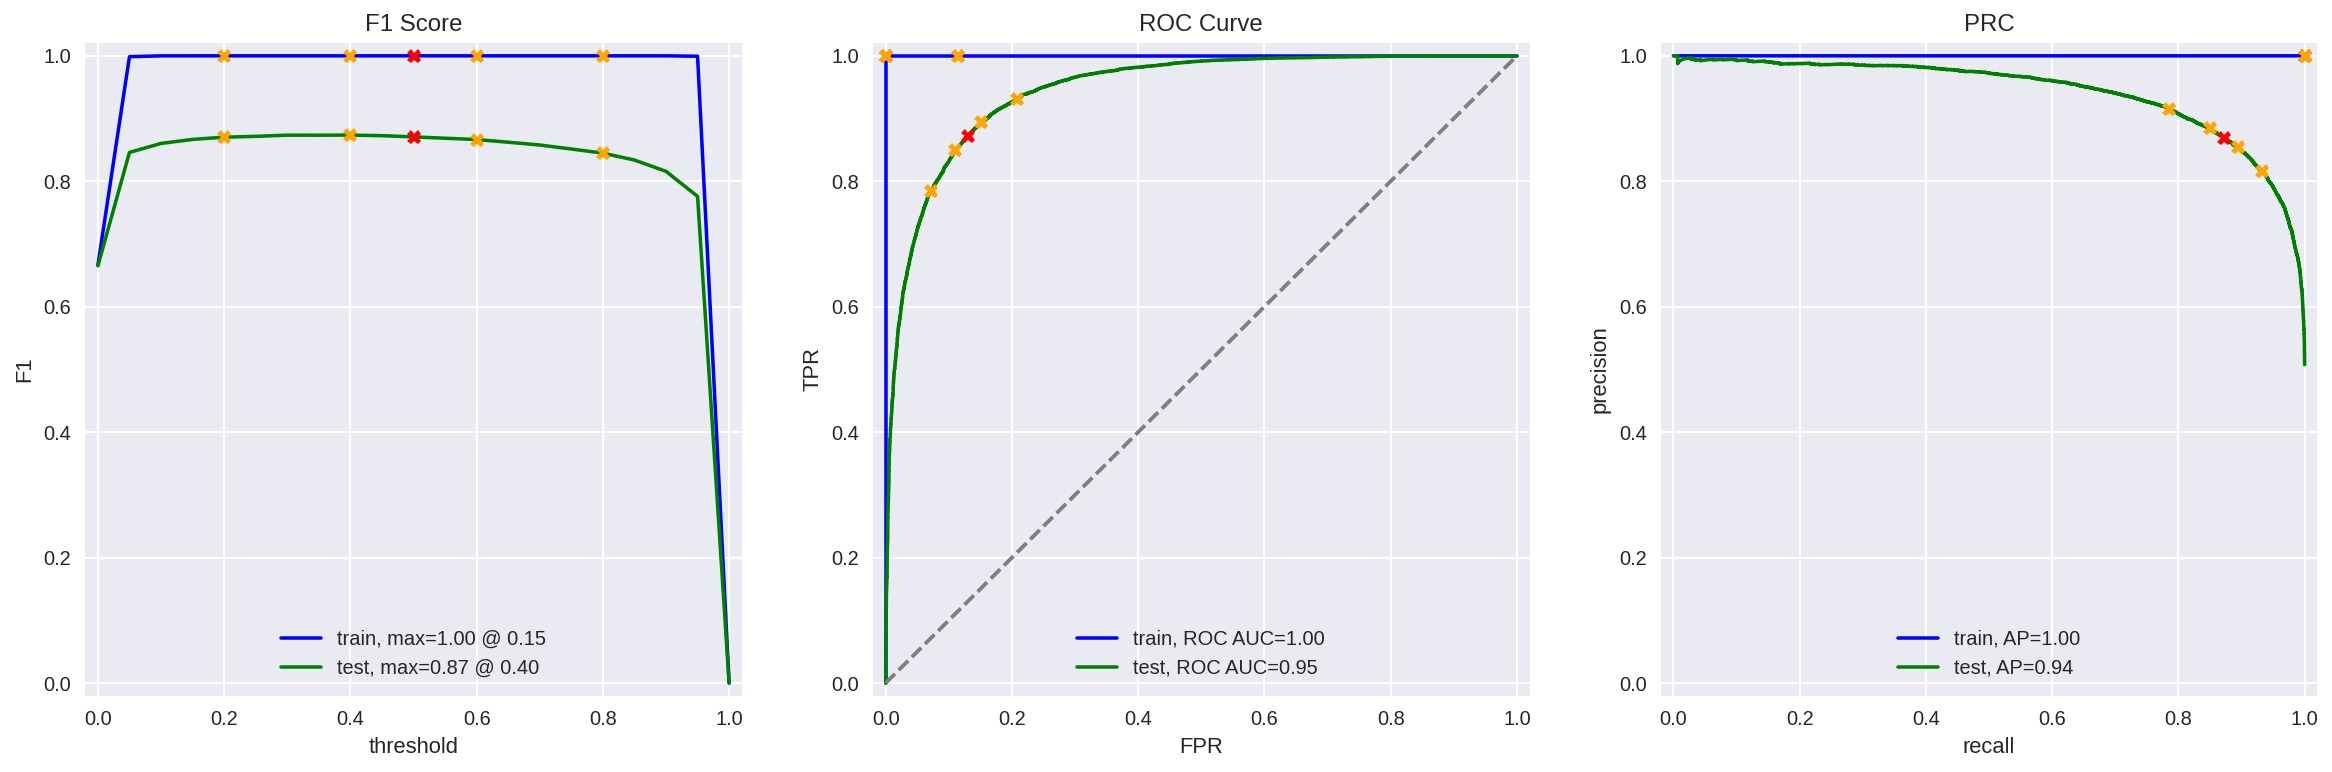

In [43]:
evaluate_model(model_4, "Model 4", train_features_3, train_target, test_features_3, test_target)

###  Model 9 - BERT

In [44]:
import torch
import transformers
from sklearn.linear_model import LogisticRegression

In [45]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=25, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    for input_text in texts:
        encoded = tokenizer.encode_plus(
            input_text,
            max_length=max_length,
            padding='max_length',  # Use 'max_length' for explicit padding to max_length
            return_tensors='pt',
            truncation=True  # Explicitly activate truncation
        )
        ids_list.append(encoded['input_ids'])
        attention_mask_list.append(encoded['attention_mask'])

    # No need to specify the device; PyTorch will use the CPU by default

    # getting embeddings in batches
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        start_idx = batch_size * i
        end_idx = min(batch_size * (i+1), len(ids_list))

        ids_batch = torch.stack(ids_list[start_idx:end_idx])
        attention_mask_batch = torch.stack(attention_mask_list[start_idx:end_idx])

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch.squeeze(), attention_mask=attention_mask_batch.squeeze())
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

    return np.concatenate(embeddings)


In [47]:
# Run the function or code to generate BERT embeddings
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'][:500])
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'][:100])

# Save the embeddings
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [48]:
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

In [49]:
train_target_9 = df_reviews_train['pos'][:500]
test_target_9 = df_reviews_test['pos'][:100]

In [50]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target_9.shape)

(23796,)
(500, 768)
(500,)


In [51]:
model_9 = LogisticRegression(random_state=12345, max_iter=1000)
model_9.fit(train_features_9, train_target_9)

LogisticRegression(max_iter=1000, random_state=12345)

          train  test    Model
Accuracy   0.99  0.83  Model 9
F1         0.99  0.82  Model 9
APS        1.00  0.92  Model 9
ROC AUC    1.00  0.92  Model 9


,train,test,Model
Accuracy,0.99,0.83,Model 9
F1,0.99,0.82,Model 9
APS,1.00,0.92,Model 9
ROC AUC,1.00,0.92,Model 9


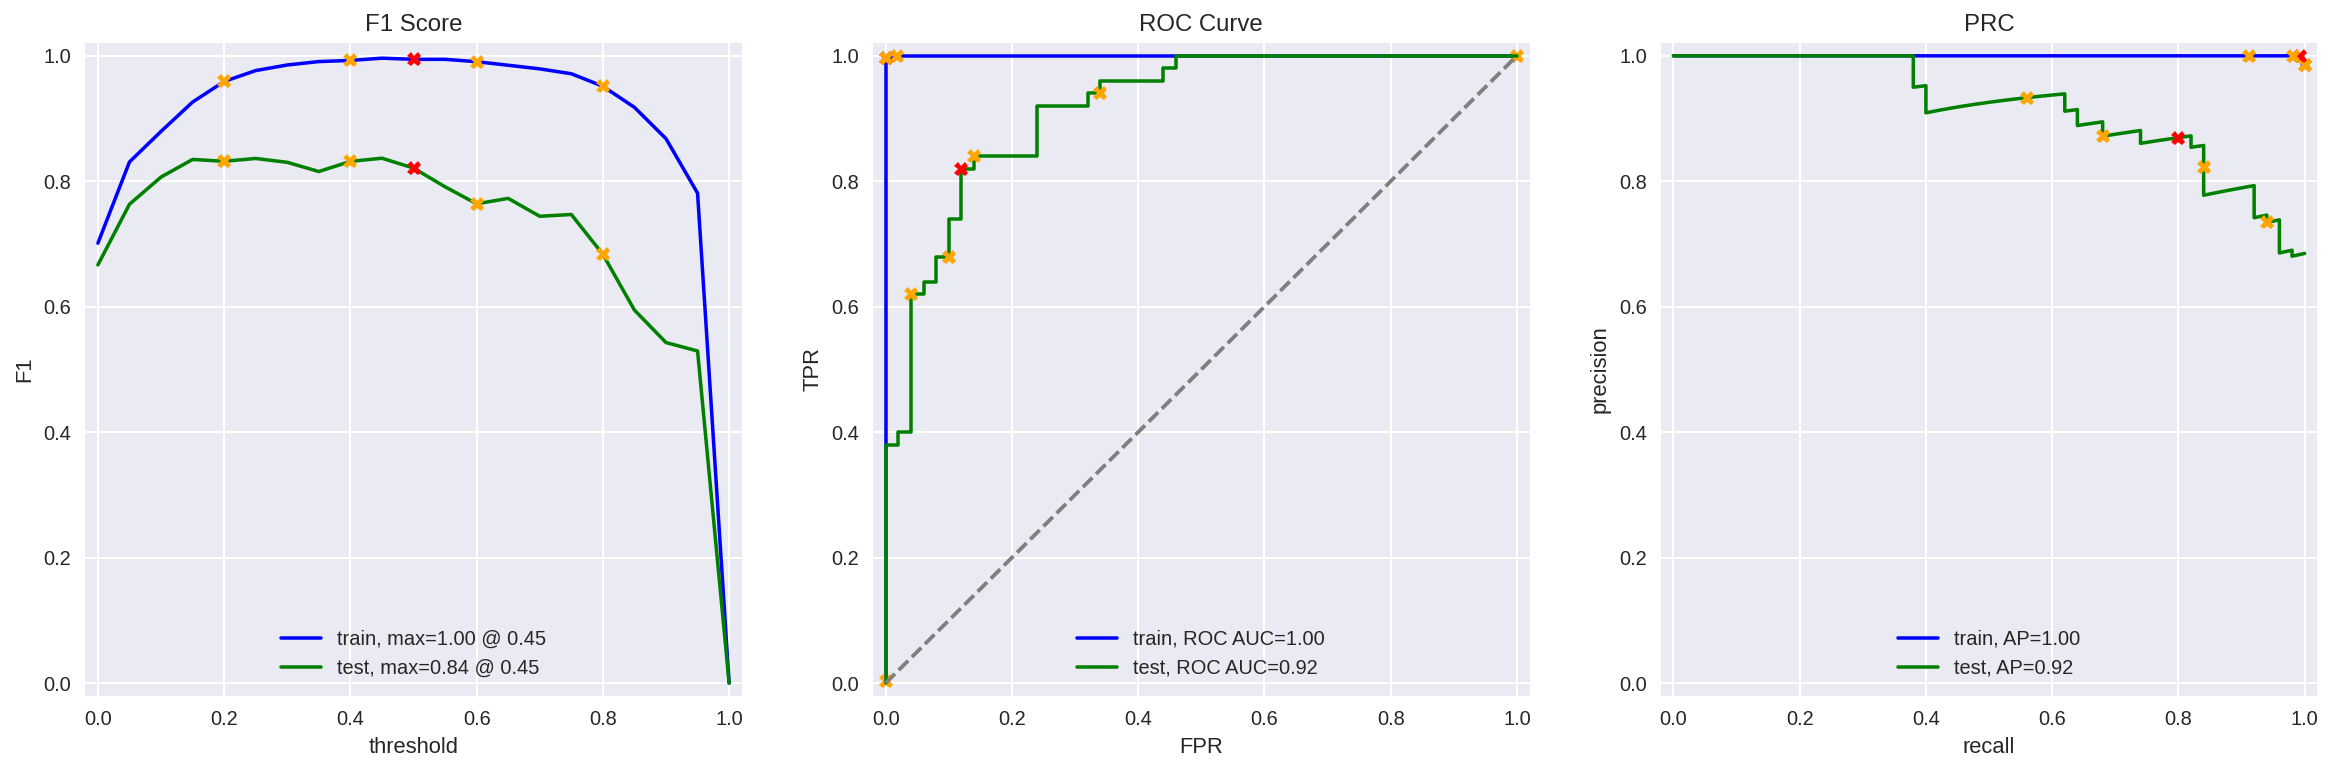

In [52]:
evaluate_model(model_9, "Model 9", train_features_9, train_target_9, test_features_9, test_target_9)

### Conclusion

          train  test    Model
Accuracy    0.5   0.5  Model 0
F1          0.5   0.5  Model 0
APS         0.5   0.5  Model 0
ROC AUC     0.5   0.5  Model 0
          train  test    Model
Accuracy   0.94  0.88  Model 1
F1         0.94  0.88  Model 1
APS        0.98  0.95  Model 1
ROC AUC    0.98  0.95  Model 1
          train  test    Model
Accuracy   0.93  0.88  Model 3
F1         0.93  0.88  Model 3
APS        0.98  0.95  Model 3
ROC AUC    0.98  0.95  Model 3
          train  test    Model
Accuracy    1.0  0.87  Model 4
F1          1.0  0.87  Model 4
APS         1.0  0.94  Model 4
ROC AUC     1.0  0.95  Model 4
          train  test    Model
Accuracy   0.99  0.83  Model 9
F1         0.99  0.82  Model 9
APS        1.00  0.92  Model 9
ROC AUC    1.00  0.92  Model 9
    train  test    Model
0    0.50  0.50  Model 0
1    0.50  0.50  Model 0
2    0.50  0.50  Model 0
3    0.50  0.50  Model 0
4    0.94  0.88  Model 1
5    0.94  0.88  Model 1
6    0.98  0.95  Model 1
7    0.98  0.95  Model 1


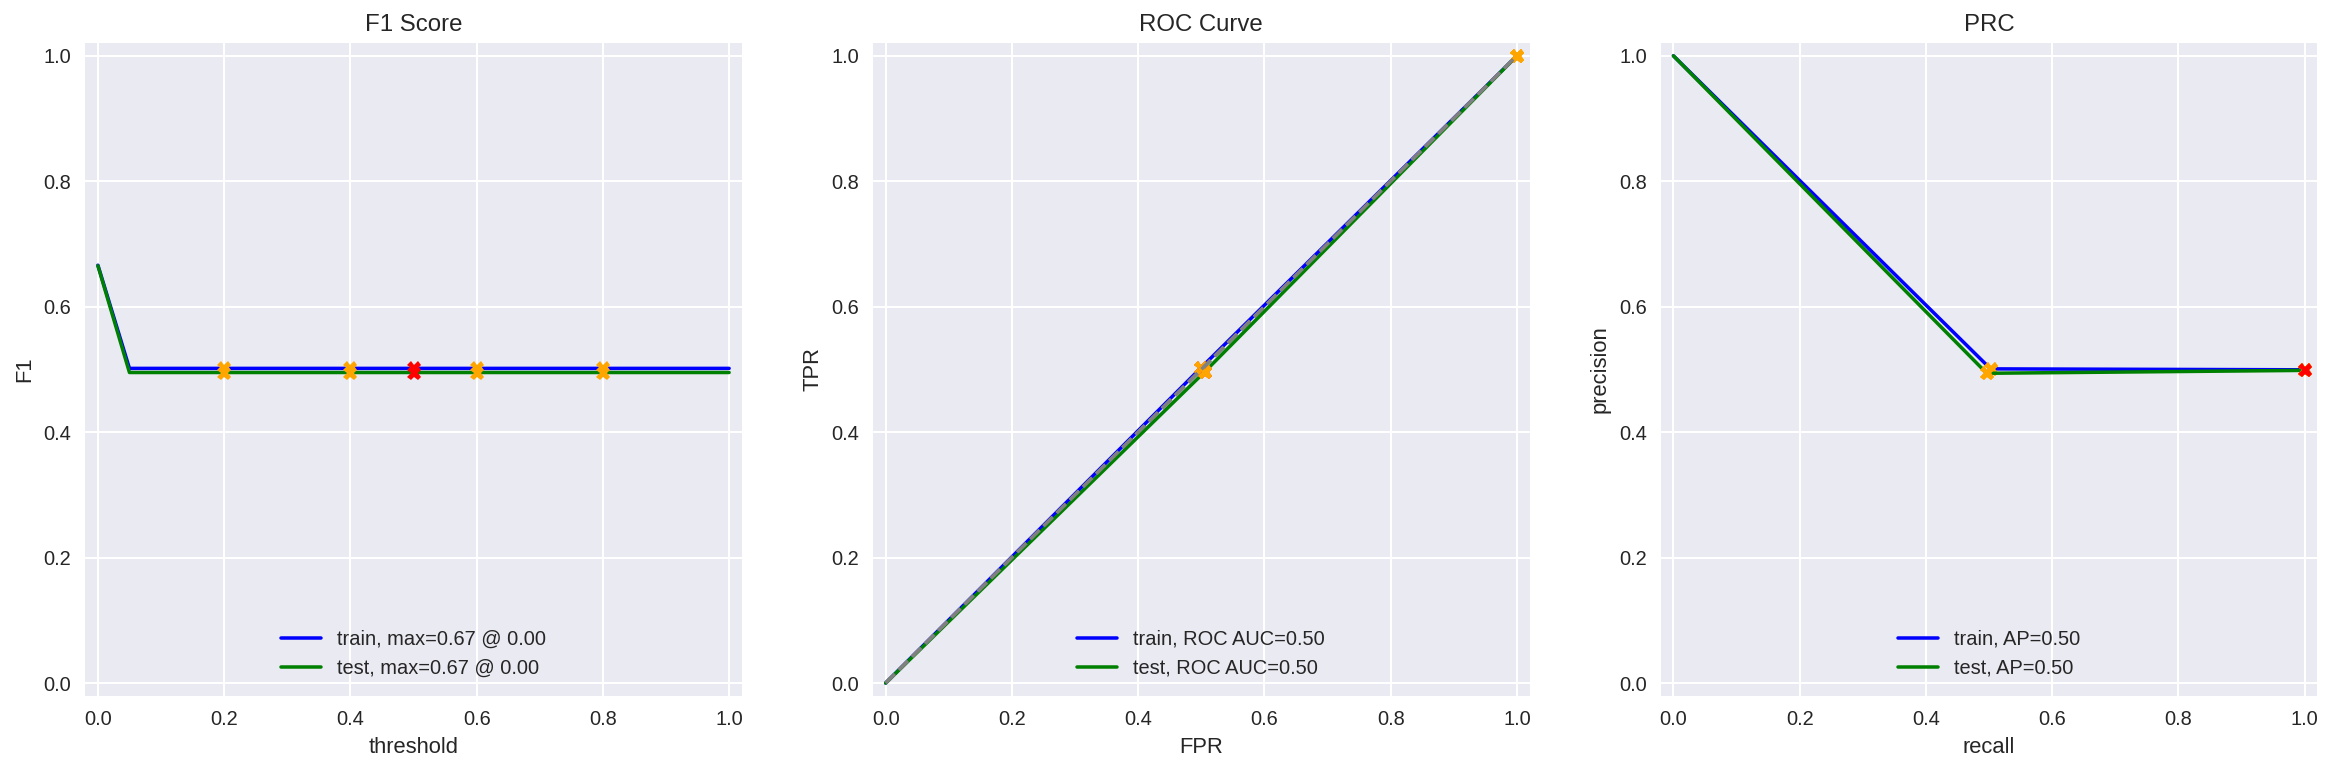

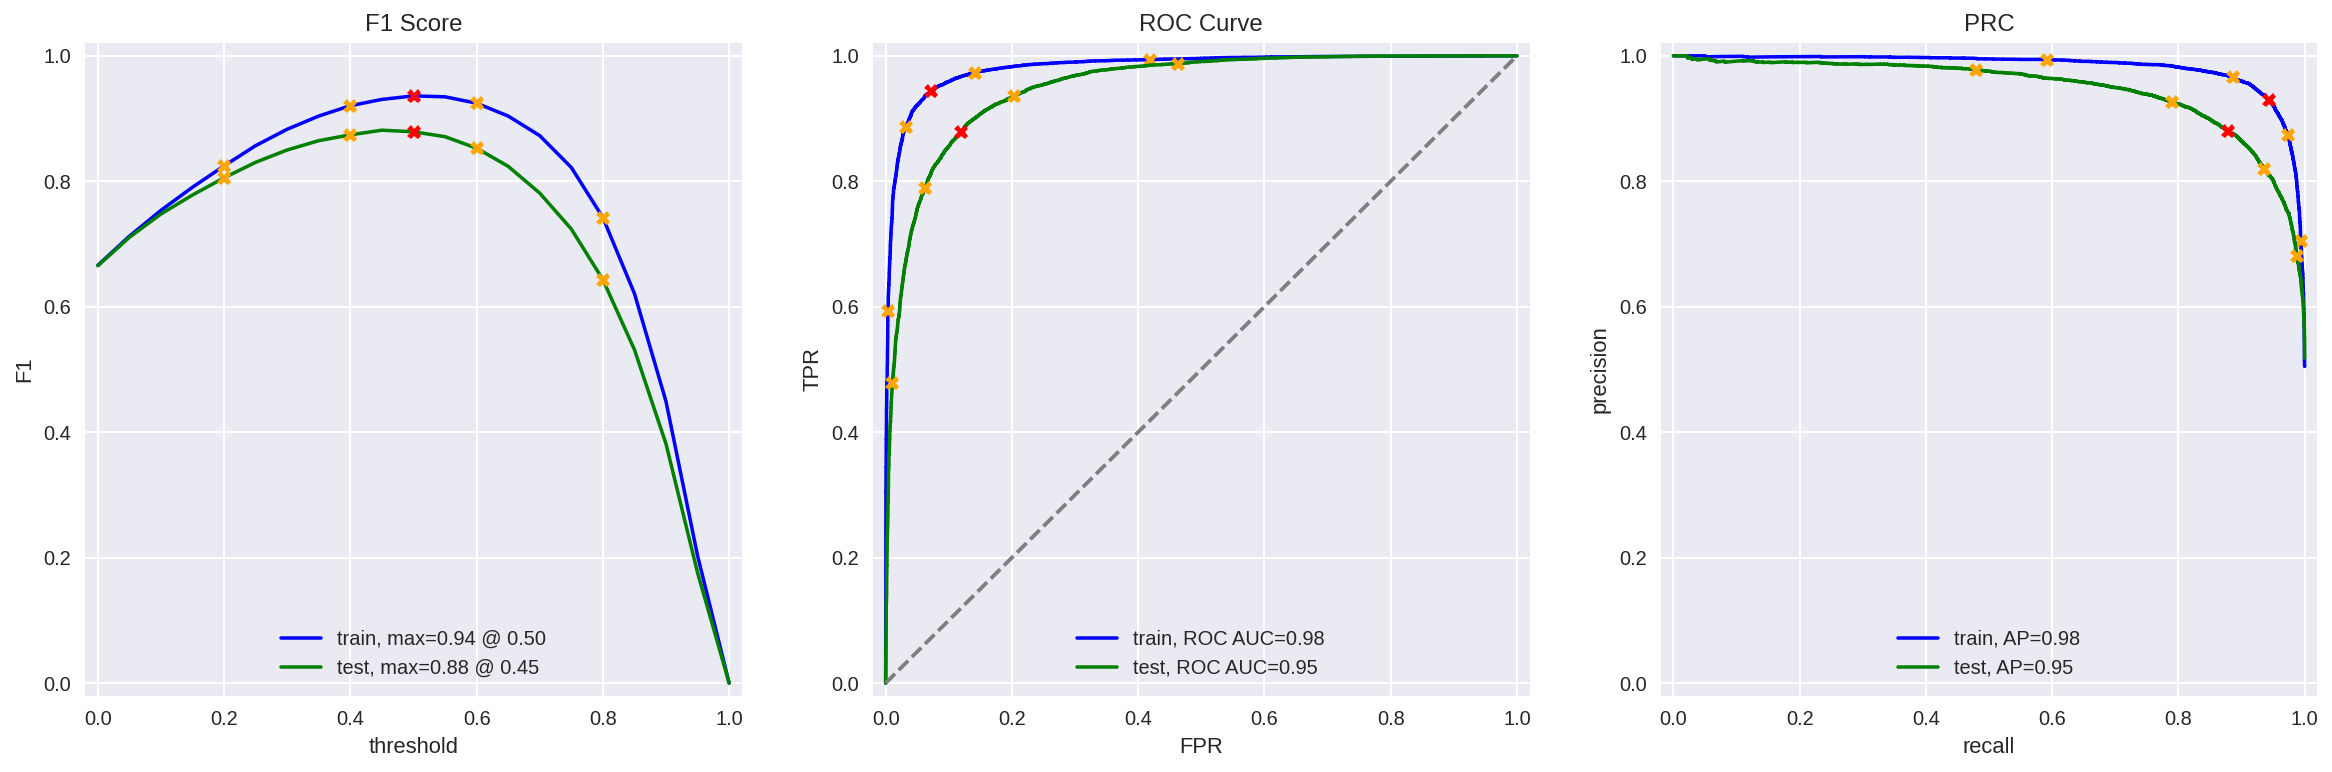

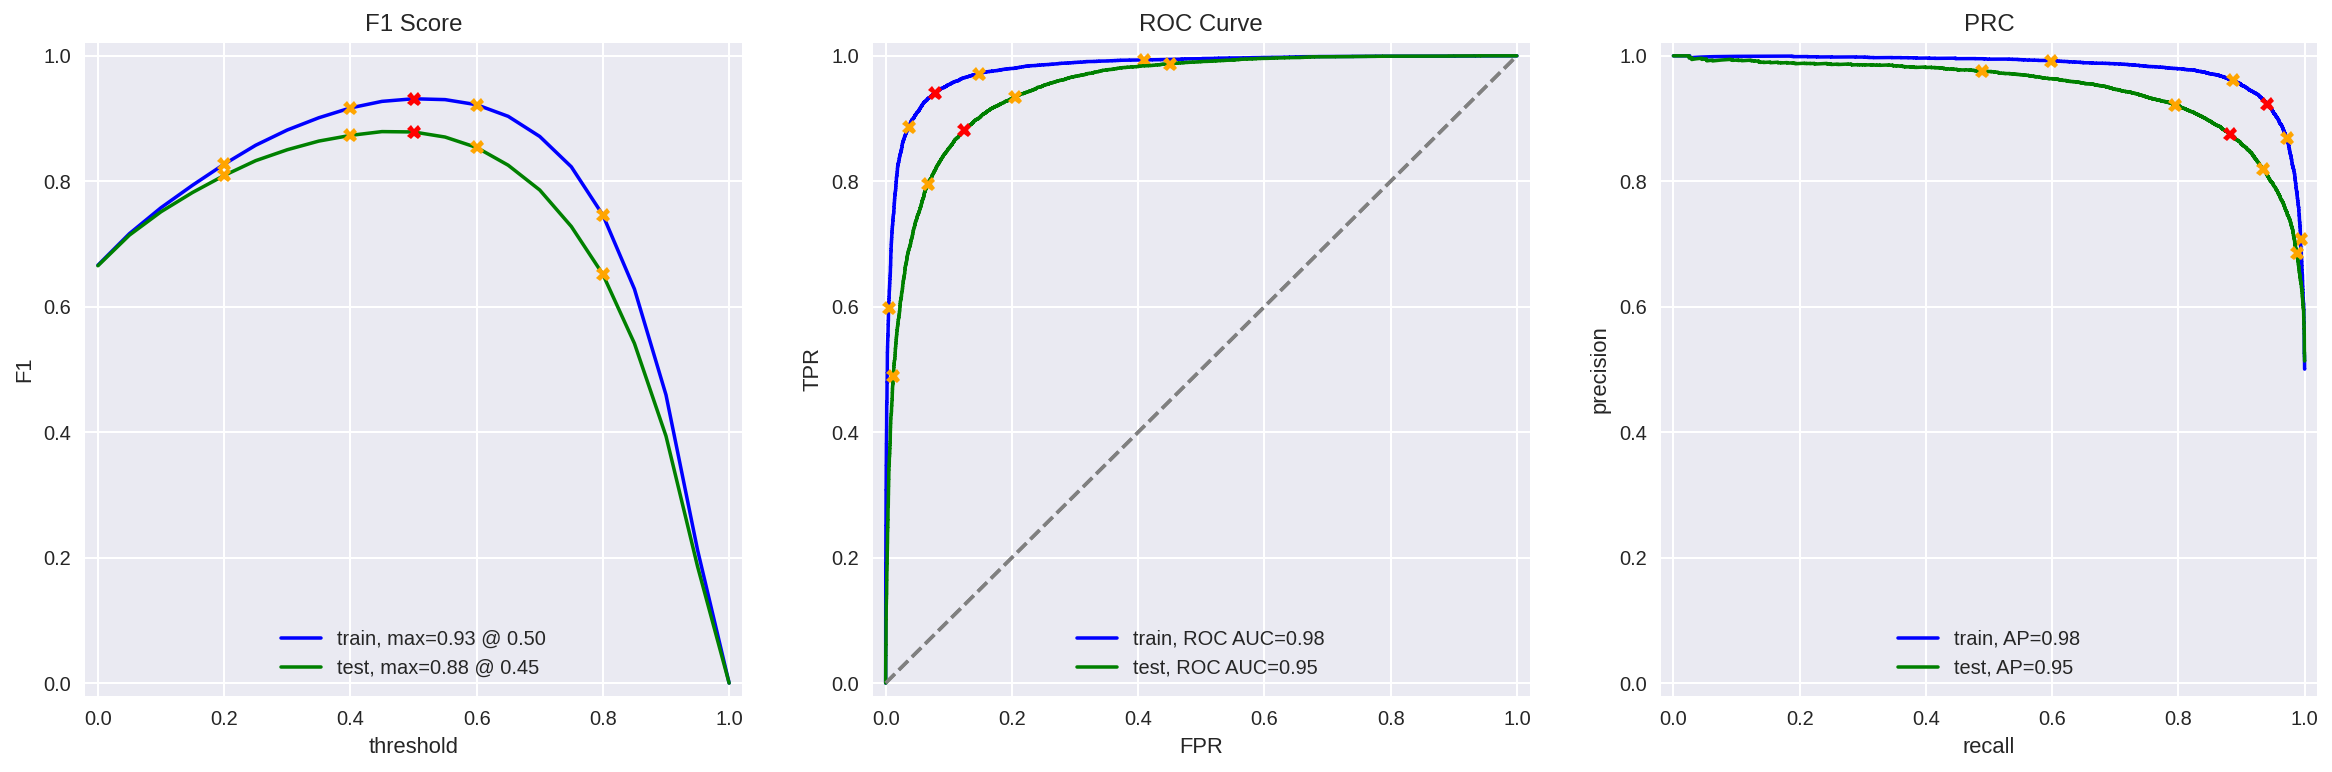

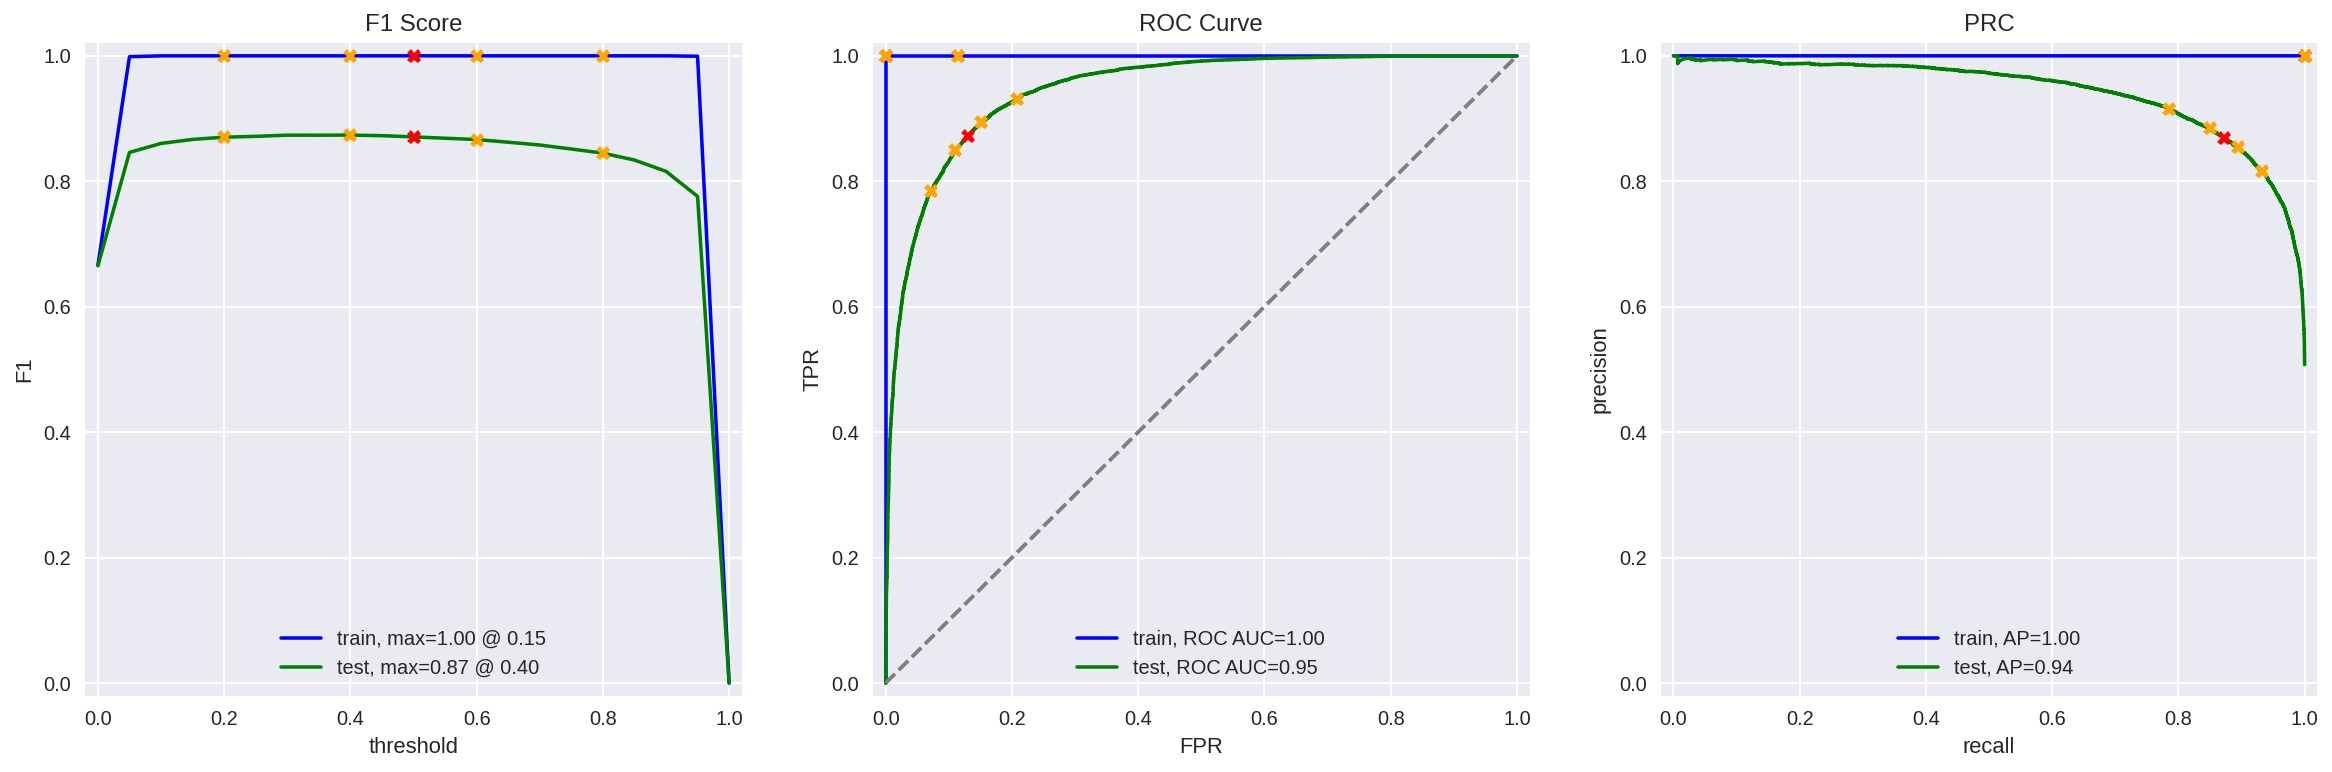

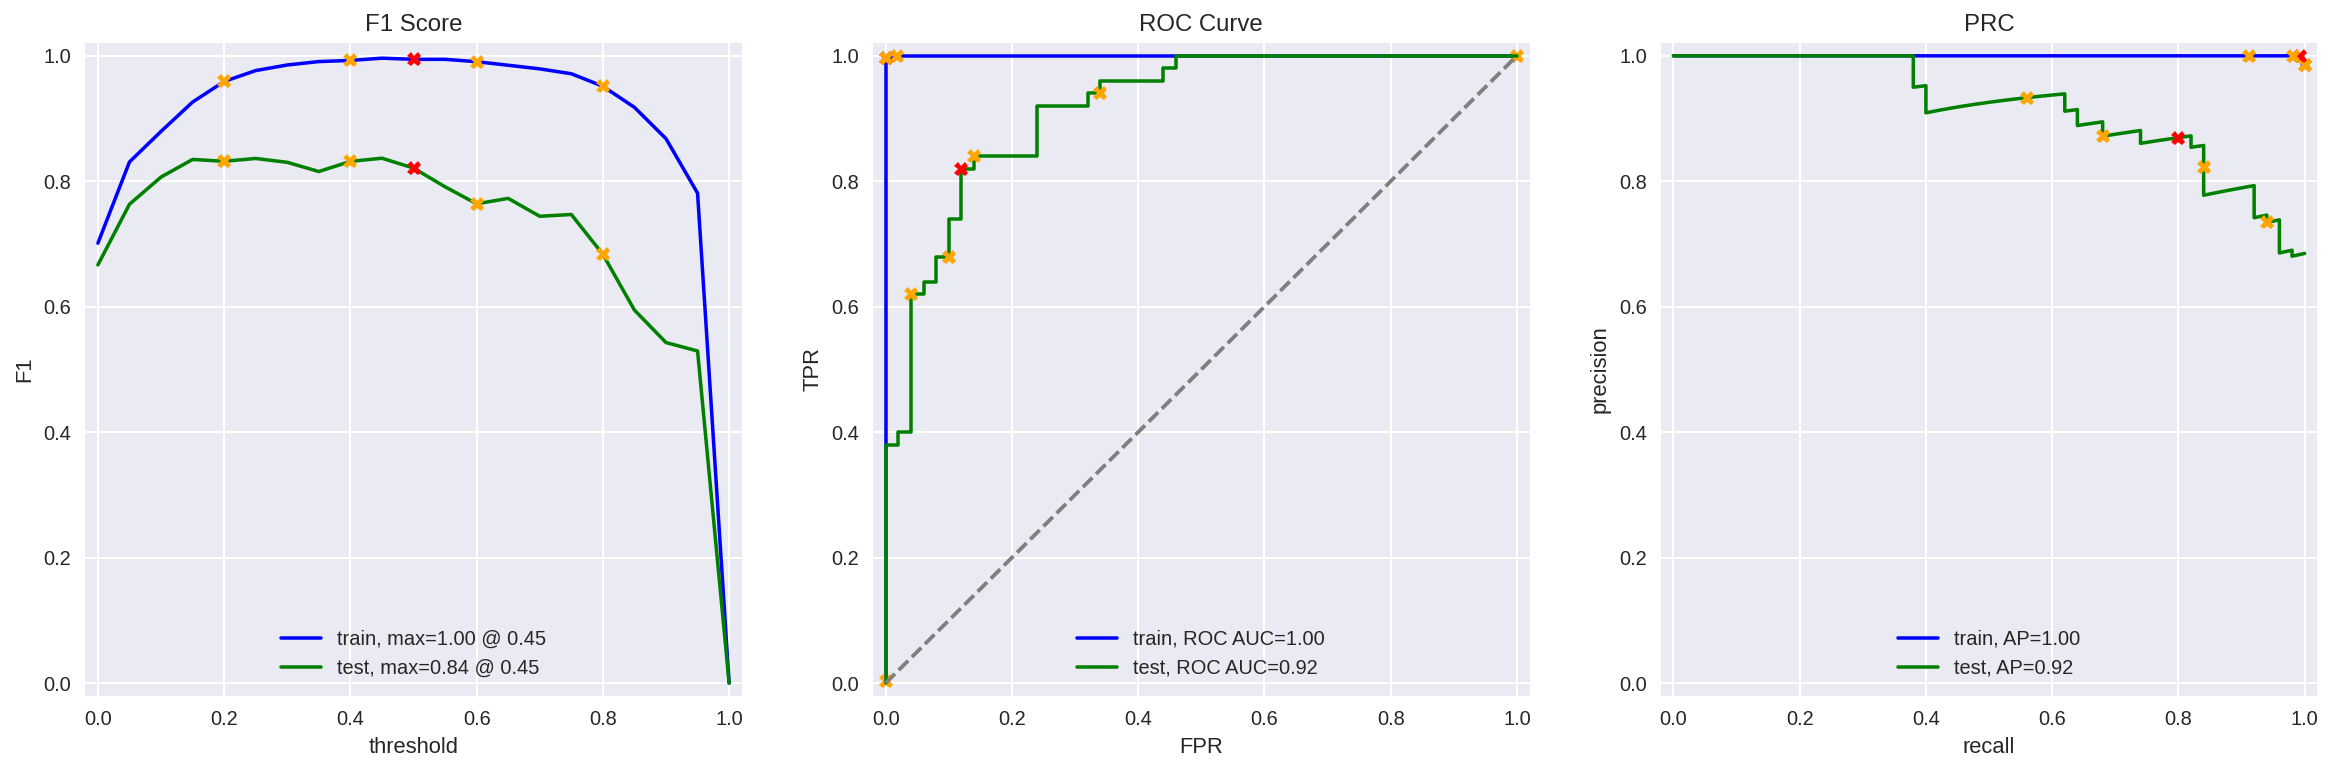

In [54]:
# Example usage for each model
df_results_0 = evaluate_model(model_0, "Model 0", train_features, train_target, test_features, test_target)
df_results_1 = evaluate_model(model_1, "Model 1", train_features_1, train_target, test_features_1, test_target)
df_results_3 = evaluate_model(model_3, "Model 3", train_features_3, train_target, test_features_3, test_target)
df_results_4 = evaluate_model(model_4, "Model 4", train_features_3, train_target, test_features_3, test_target)
df_results_9 = evaluate_model(model_9, "Model 9", train_features_9, train_target_9, test_features_9, test_target_9)

# Combine results into one DataFrame
df_combined_results = pd.concat([df_results_0, df_results_1, df_results_3, df_results_4, df_results_9], ignore_index=True)

# Display the combined DataFrame
print(df_combined_results)


1. The dummy model has F1 of 0.5 on testing dataset.
2. Model 1 - NLTK, TF-IDF and LR, Model 3 - spaCy, TF-IDF and LR & Model 4 - spaCy, TF-IDF and LGBMClassifier have the same F1 socre of 0.88 on teesting dataset.
3. Model 9 - BERT has the least F1 score of 0.82 on testing dataset. But this can be further improved by increasing the training and testing features to be embedded. As for this testing, we only include 500 training dataset & 100 testing dataset to reduce the running time. The time taken for this test took around 1 hour.

## My Reviews

In [55]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: " ".join(re.sub(r"[^A-Za-z]", " ", x.lower()).split())) # <put here the same normalization logic as for the main dataset>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 1

In [65]:
texts = my_reviews['review_norm']

my_reviews_pred_prob_2 = model_1.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_2[i]:.2f}:  {review}')
    
my_reviews['Model_1_Sentiment_Score'] = my_reviews_pred_prob_2.round(2)

0.15:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.57:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.36:  i didn t expect the reboot to be so good writers really cared about the source material
0.51:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [57]:
my_reviews['review_norm']

my_reviews_pred_prob_3 = model_3.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_3[i]:.2f}:  {review}')
    
my_reviews['Model_3_Sentiment_Score'] = my_reviews_pred_prob_3.round(2)

0.20:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.48:  i was really fascinated with the movie
0.32:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.45:  i didn t expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.94:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [58]:
texts = my_reviews['review_norm']

my_reviews_pred_prob_4 = model_4.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_4[i]:.2f}:  {review}')
    
my_reviews['Model_4_Sentiment_Score'] = my_reviews_pred_prob_4.round(2)

0.40:  i did not simply like it not my kind of movie
0.08:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.23:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.16:  i didn t expect the reboot to be so good writers really cared about the source material
0.94:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1.00:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 9

In [60]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob_9 = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_9[i]:.2f}:  {review}')
    
my_reviews['Model_9_Sentiment_Score'] = my_reviews_pred_prob_9.round(2)

0.78:  i did not simply like it not my kind of movie
0.05:  well i was bored and felt asleep in the middle of the movie
0.86:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.46:  i didn t expect the reboot to be so good writers really cared about the source material
0.99:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.01:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.98:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Conclusion

In [66]:
# Display the table
print(my_reviews[['review', 'Model_1_Sentiment_Score', 'Model_3_Sentiment_Score', 'Model_4_Sentiment_Score', 'Model_9_Sentiment_Score']])

                                              review  Model_1_Sentiment_Score  \
0    I did not simply like it, not my kind of movie.                     0.15   
1  Well, I was bored and felt asleep in the middl...                     0.18   
2             I was really fascinated with the movie                     0.57   
3  Even the actors looked really old and disinter...                     0.14   
4  I didn't expect the reboot to be so good! Writ...                     0.36   
5  The movie had its upsides and downsides, but I...                     0.51   
6  What a rotten attempt at a comedy. Not a singl...                     0.03   
7  Launching on Netflix was a brave move & I real...                     0.88   

   Model_3_Sentiment_Score  Model_4_Sentiment_Score  Model_9_Sentiment_Score  
0                     0.20                     0.40                     0.78  
1                     0.12                     0.08                     0.05  
2                     0.48       

1. For the 1st statement, "i did not simply like it not my kind of movie", shall be negative reviews. But only model 1 & 3 scores are nearer to zero, which indicate the negative reviews.

2. For the 2nd statement, "well i was bored and felt asleep in the middle of the movie", shall be negative reviews. All 4 models have scores nearer to zero, which is quite accurate. But Model 4 & 9 provided lower scores than model 1 & 3, that means Model 4 & 9 are more accurate for this case.

3. The 3rd statement, "i was really fascinated with the movie", is the positive review. Model 9 has the higher score nearer to 1, followed by model 1 & 4, which are around 0.57.

4. The statement "even the actors looked really old and disinterested and they got paid to be in the movie what a soul", is a negative review. All 4 models detects correctly.

5. "i didn t expect the reboot to be so good writers really cared about the source material" statement is a neutral statement to me, only Model 4 give lower score to show it is a negative review.

6. "the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse" is a neutral to positive. Model 1 & 3 predicted as neutral while Model 4 & 9 predicted as positive.

7. "what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids" is a negative review. All models detected almost near to zero scores.

8. "launching on netflix was a brave move i really appreciate being able to binge on episode after episo" is a positive review. All models have scores more than 0.8.

## Conclusions

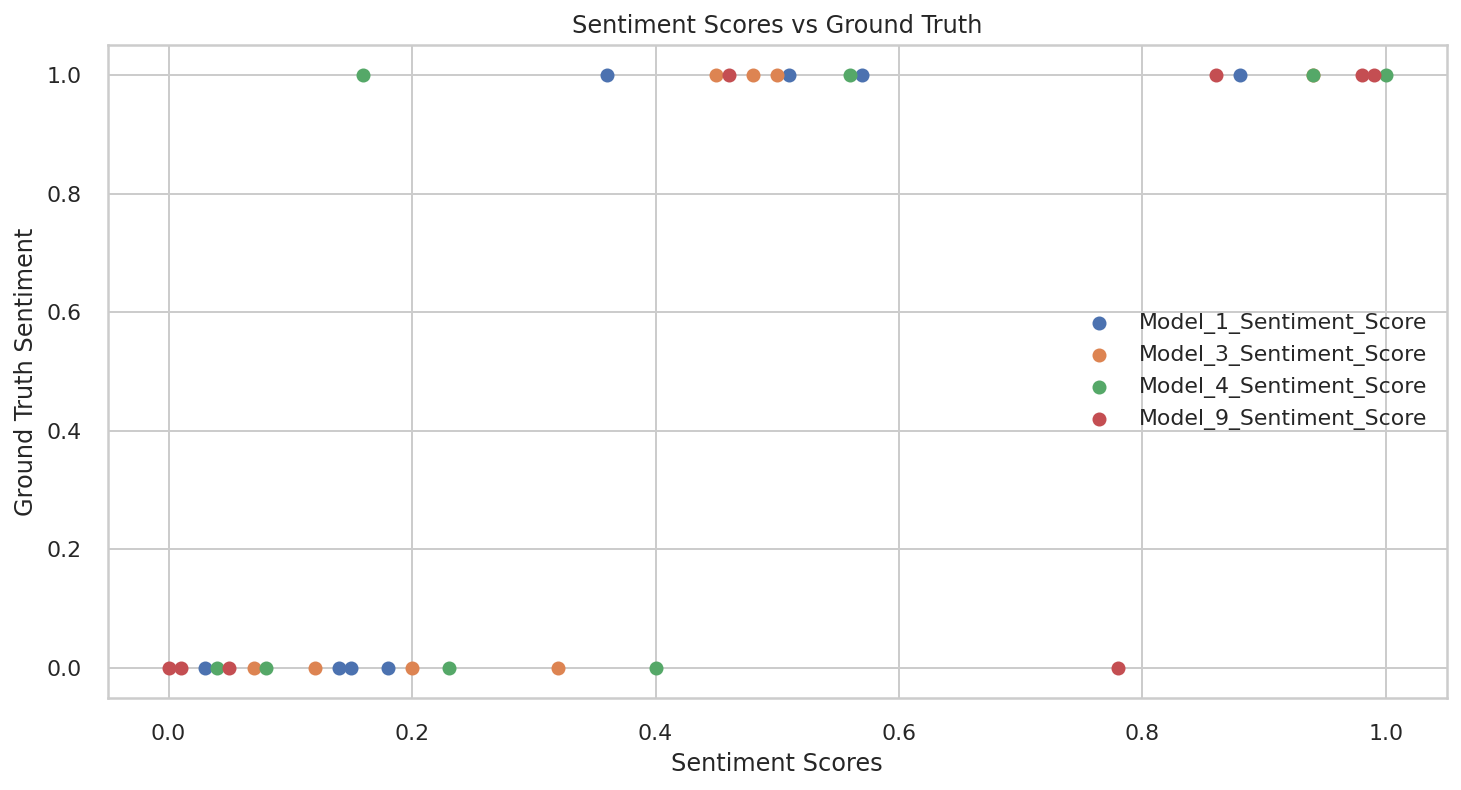

Average Sentiment Scores:
Model_1_Sentiment_Score    0.35250
Model_3_Sentiment_Score    0.38500
Model_4_Sentiment_Score    0.42625
Model_9_Sentiment_Score    0.51625
dtype: float64

Correlation with Ground Truth:
Model_1_Sentiment_Score    0.852032
Model_3_Sentiment_Score    0.796899
Model_4_Sentiment_Score    0.678625
Model_9_Sentiment_Score    0.739891
dtype: float64


In [68]:
from scipy.stats import pearsonr

# Ground truth sentiment labels (positive, neutral, negative)
ground_truth_sentiment = ['negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive']

# Extracting sentiment scores from the DataFrame
model_columns = ['Model_1_Sentiment_Score', 'Model_3_Sentiment_Score', 'Model_4_Sentiment_Score', 'Model_9_Sentiment_Score']
sentiment_scores = my_reviews[model_columns]

# 1. Average Sentiment Scores
average_scores = sentiment_scores.mean()

# 2. Correlation with Ground Truth
correlations = sentiment_scores.apply(lambda x: pearsonr(x, pd.factorize(ground_truth_sentiment)[0])[0])

# 3. Visual Inspection
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

for model_column in model_columns:
    plt.scatter(my_reviews[model_column], pd.factorize(ground_truth_sentiment)[0], label=model_column)

plt.legend()
plt.xlabel('Sentiment Scores')
plt.ylabel('Ground Truth Sentiment')
plt.title('Sentiment Scores vs Ground Truth')
plt.show()

# Display results
print("Average Sentiment Scores:")
print(average_scores)

print("\nCorrelation with Ground Truth:")
print(correlations)

1. For the 3 models with TF-IDF vectoriser, they have almost the same F1 score, although they are using different natural language processings, NLTK or spaCy. And among the 3 of these models, 2 are using linear regression and 1 is gradient boositng model.

2. BERT has the least F1 score of 0.82 on testing dataset. But this can be further improved by increasing the training and testing features to be embedded and also the batch size. As for this testing, we only include 500 training dataset & 100 testing dataset to reduce the running time. The time taken for this test took around 1 hour.

3. For the custom reviews testing, we can conclude that Model 1 is the most positively correlated with ground truth, follow by Model 3, 9 and the last is Model 4.